In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib
import sys

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = 12
# plt.rcParams['text.usetex'] = True

sys.path.insert(0, '/home/aew492/CFE_gradients/code')
from load_tools import load_suave_amps

In [2]:
cat_tag = 'L750_n2e-4_z057_patchy_As2x'
data_dir = '/scratch/aew492/CFE_gradients_output'

In [3]:
"""given volume, number density, and representative power spectrum value,
    return the expected precision of the CF estimation: equation from Weinberg OSU"""
def std_grad(V, n, P):
    std = P * (V**(-.5) * (1 + (n*P)**(-1))) * (V**(-1/3))  # last factor is from position dependence across box
    return std

In [4]:
# find corresponding k, and P_G(k), for some input separation r
def get_PkG(r, PkG_fn='/scratch/ksf293/mocks/lognormal/inputs/cat_L750_n2e-4_z057_patchy_As2x_pkG.dat'):
    kG, PkG = np.loadtxt(PkG_fn).T
    
    k = min(kG, key=lambda x:abs(x-1/r))  # closest k value to 1/r
    P = PkG[np.where(kG==k)][0]
    return k, P

### plot slices of mock catalogs

In [5]:
# weak ('more realistic') gradient mock
m1 = 0.1
mock1_dict = np.load(os.path.join(data_dir, f'catalogs/gradient/1D/{cat_tag}/{cat_tag}_rlz0_m-{m1:.3f}-L_b-0.500.npy'), allow_pickle=True).item()
mock1_data = mock1_dict['data']
mock1_w_hat = mock1_dict['w_hat']
mock1_boxsize = mock1_dict['L']

In [6]:
# strong gradient mock, where we can visually see the change in clustering
m2 = 1
mock2_dict = np.load(os.path.join(data_dir, f'catalogs/gradient/2D/{cat_tag}/{cat_tag}_rlz0_m-{m2:.3f}-L_b-0.500.npy'), allow_pickle=True).item()
mock2_data = mock2_dict['data']
mock2_w_hat = mock2_dict['w_hat']
mock2_boxsize = mock2_dict['L']

In [7]:
# super strong gradient mock
m3 = 20
mock3_dict = np.load(os.path.join(data_dir, f'catalogs/gradient/2D/{cat_tag}/{cat_tag}_rlz0_m-{m3:.3f}-L_b-0.500.npy'), allow_pickle=True).item()
mock3_data = mock3_dict['data']
mock3_w_hat = mock3_dict['w_hat']
mock3_boxsize = mock3_dict['L']

In [8]:
# no gradient gradient mock
m4 = 0
mock4_dict = np.load(os.path.join(data_dir, f'catalogs/lognormal/{cat_tag}/{cat_tag}_rlz0_lognormal.npy'), allow_pickle=True).item()
mock4_data = mock4_dict['data'] - 375
# mock4_w_hat = mock4_dict['w_hat']
mock4_boxsize = mock4_dict['L']

In [9]:
mock_data = [mock4_data, mock1_data, mock2_data, mock3_data]
gradients = [np.array([0,0,0]), m1*mock1_w_hat, m2*mock2_w_hat, m3*mock3_w_hat]

In [10]:
# xy-slice for plotting
z_max = -200
data_slices = []
for data_set in mock_data:
    data_slices.append(data_set[np.where(data_set[:,2] < z_max)])

In [11]:
# plotting w_hat
def arrow(gradient):
    cent = [0,0]
    base = cent-gradient[:2]/2
    head = cent+gradient[:2]/2
    return base, head

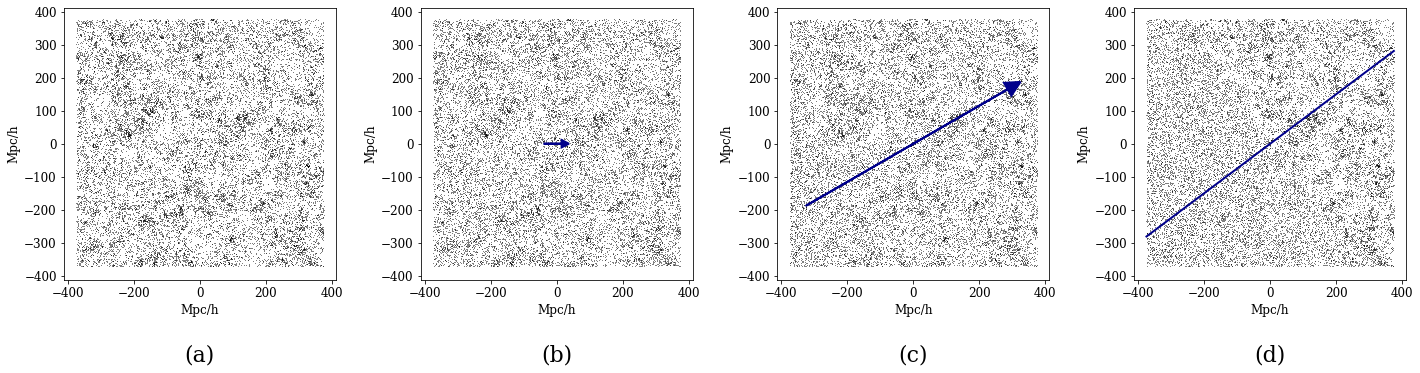

In [12]:
fig, axs = plt.subplots(1, 4, figsize=(20,5))

# plot galaxies
i = 0

L = mock1_boxsize
color='darkblue'
lw=2
As = [1,1,0.2,0.2]

titles = ['(a)', '(b)', '(c)', '(d)']

for col in range(4):
    ax = axs[col]
    data = data_slices[i]
    ax.plot(data[:,0], data[:,1], 'k,', alpha=0.5)
    ax.set_title(titles[col], y=-.32, fontsize=22)
    # ax.set_title(r'$\omega_{input}$'+' = [ {:.2f},  {:.2f},  {:.2f} ]'.format(gradients[i][0], gradients[i][1], gradients[i][2]))

    # plot w_hat arrow
    if i == 3:
        x = np.linspace(-L/2,L/2,2)
        ax.plot(x,0.75*x,color=color, lw=lw, zorder=100)

    else:
        base, head = arrow(gradients[i])
        b = np.linalg.norm(head-base)
        ax.arrow(L*base[0], L*base[1], 2*L*head[0], 2*L*head[1], color=color, lw=lw,
                 head_width=0.3*As[i]*L*b, head_length=0.3*As[i]*L*b, length_includes_head=True, zorder=100)
    ax.set_aspect('equal')
    ax.set_xlabel('Mpc/h')
    ax.set_ylabel('Mpc/h')
    i += 1
fig.tight_layout()

### Landy-Szalay results

In [13]:
ls_results = np.load(os.path.join(data_dir, f'lognormal/ls/{cat_tag}/xi_ls_3x_{cat_tag}_rlz0_lognormal.npy'), allow_pickle=True)
ls_results.shape

(2, 22)

In [14]:
nmocks = 401

In [15]:
ls_results = np.empty((nmocks,22))
for i in range(nmocks):
    r_avg, ls_results[i] = np.load(os.path.join(data_dir, f'lognormal/ls/{cat_tag}/xi_ls_3x_{cat_tag}_rlz{i}_lognormal.npy'), allow_pickle=True)

In [16]:
ls_avg = np.mean(ls_results, axis=0)
ls_avg.shape

(22,)

### CFE results

In [17]:
cfe_results = np.load(os.path.join(data_dir, f'lognormal/suave/xi/bao_fixed/{cat_tag}/xi_{cat_tag}_rlz0_lognormal.npy'), allow_pickle=True)
cfe_results.shape

(2000, 2)

In [18]:
cfe_results = np.empty((nmocks,2000))
for i in range(nmocks):
    r_fine, cfe_results[i] = np.load(os.path.join(data_dir, f'lognormal/suave/xi/bao_fixed/{cat_tag}/xi_{cat_tag}_rlz{i}_lognormal.npy'), allow_pickle=True).T

In [19]:
cfe_avg = np.mean(cfe_results, axis=0)

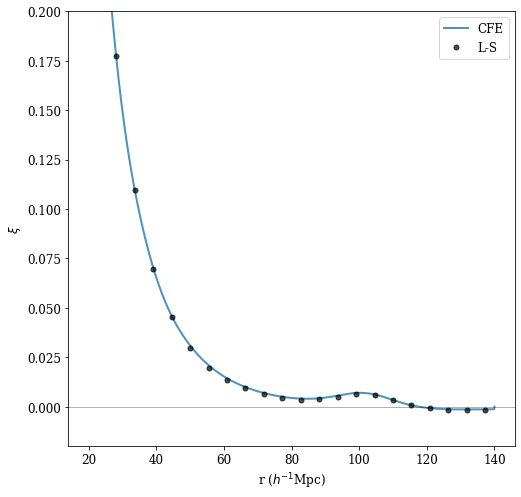

In [20]:
fig, ax = plt.subplots(figsize=(8,8))

ax.plot(r_fine, cfe_avg, alpha=0.8, lw=2, label='CFE')
ax.plot(r_avg, ls_avg, marker='.', ms=10, color='k', ls='None', alpha=0.7, label='L-S')


ax.axhline(0, color='k', alpha=0.3, lw=1)
ax.set_ylim((-.02, 0.2))
ax.set_xlabel(r'r ($h^{-1}$Mpc)')
ax.set_ylabel(r'$\xi$')
ax.legend()

### CFE gradient results

In [21]:
xi_results = np.load(os.path.join(data_dir, f'plot_data/xi_locs_L750_n2e-4_m-1.000-L_b-0.500_50vs.npy'), allow_pickle=True).item()
vs = xi_results['vs']
r_fine = xi_results['r_fine']
xi_locs = xi_results['xi_locs']

In [22]:
vmin = min(vs)
vmax = max(vs)
vs_norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
cmap = matplotlib.cm.get_cmap('cool')

Text(0, 0.5, '$\\xi(r)$')

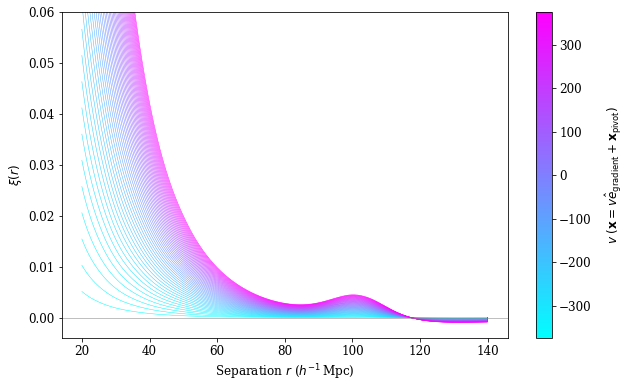

In [23]:
fig, ax = plt.subplots(figsize=(10,6))

for i, v in enumerate(vs):
    p = ax.plot(r_fine, xi_locs[i], color=cmap(vs_norm(v)), lw=0.5)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=vs_norm)
cbar = plt.colorbar(sm)
cbar.set_label(r"$v \,\, (\mathbf{x} = v\hat{e}_\mathrm{gradient} + \mathbf{x}_\mathrm{pivot})$", rotation=90, labelpad=12)
ax.axhline(0, color='grey', lw=0.5)
ax.set_ylim((-0.004, 0.06))
ax.set_xlabel(r"Separation $r$ ($h^{-1}\,$Mpc)")
ax.set_ylabel(r"$\xi(r)$")

### Precision scalings

In [24]:
# from the expected_precision notebook, we've decided to use PkG at r=40 as our representative value:
k_rep, P_rep = get_PkG(40)

#### Boxsize

In [25]:
Ls = [500, 750, 1000, 1500]
n = '1e-5'
grad_dim = 1
m = 1
b = 0.5

In [27]:
amp_arr = np.empty((len(Ls),401,4))

for i, L in enumerate(Ls):
    amp_arr[i] = load_suave_amps(L=L, n=n, grad_dim=grad_dim, m=m, b=b)

In [28]:
# compress the amplitudes along the realizations to get the spread for each amplitude for each boxsize
amp_stds_L = np.std(amp_arr, axis=1)  # (4,4) array

In [29]:
Ls_cont = np.linspace(min(Ls), max(Ls), 100)
expected_scalings = std_grad(Ls_cont**3, float(n), P_rep)

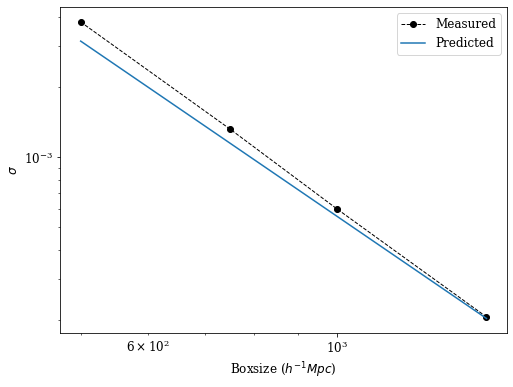

In [30]:
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(Ls, amp_stds_L[:,1], marker='o', ls='--', lw=1, color='k', label='Measured')
ax.plot(Ls_cont, expected_scalings*10**-1, label='Predicted')

ax.set_xlabel('Boxsize ($h^{-1}Mpc$)')
ax.set_ylabel('$\sigma$')
# ax.set_title('Precision scalings with boxsize')

ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()